In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARN', verbose=False)
    
import astropy.io.fits as fits

In [3]:
# Initialize a NIRCam Grism observation in Stripe mode 
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', module='A', 
                   wind_mode='STRIPE', xpix=2048, ypix=64, fov_pix=64)

In [4]:
# Update ramp settings
nrc.update_detectors(read_mode='RAPID', nint=1, ngroup=70, verbose=True)

New Ramp Settings:
  read_mode :    RAPID
  nf        :        1
  nd2       :        0
  ngroup    :       70
  nint      :        1
New Detector Settings
  wind_mode :   STRIPE
  xpix      :     2048
  ypix      :       64
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :    0.341
  t_frame   :    0.341
  t_int     :   23.843
  t_int_tot :   24.183
  t_exp     :   23.843
  t_acq     :   24.183


In [5]:
# Setup Pysynphot spectrum of the source
# K7V star normalized to K=10.2 mag
bpk = S.ObsBandpass('johnson,k')
sp = pynrc.stellar_spectrum('G2V', 8, 'vegamag', bpk)

In [6]:
# Specify name of output file.
# Time stamps will be automatically inserted for unique file names.
file_out = '/Volumes/NIRData/grism_sim/grism_sim.fits'
res_sp = nrc.gen_exposures(sp, file_out=None)

1.18264392213


In [7]:
# Plot the ideal grism spectrum and slope image
w, im_slope = nrc.gen_psf(sp)
im_slope += nrc.bg_zodi()

1443.97569296


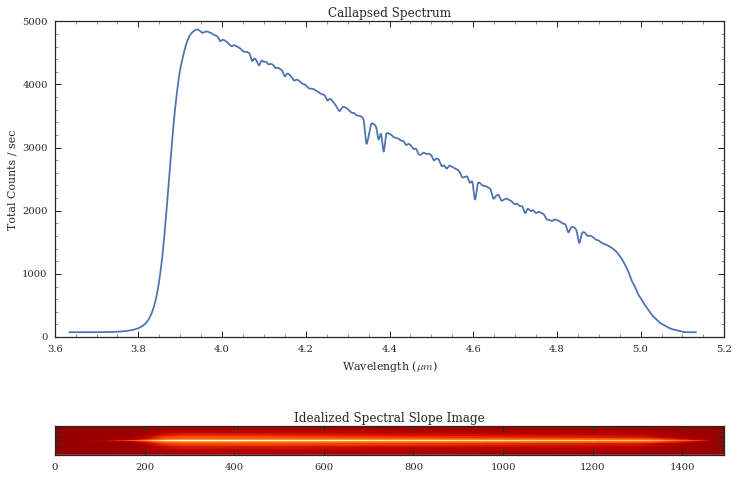

In [8]:
# For fun, plot the collapsed spectral image w.r.t. wavelength
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(7,1)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[-1, :])

# Collapsed spectrum
ax1.plot(w, im_slope.sum(axis=0))
ax1.set_ylabel('Total Counts / sec')
ax1.set_xlabel('Wavelength ($\mu m$)')
ax1.set_title('Callapsed Spectrum')
ax1.minorticks_on()

# Show the 2D spectral image as well
vmin = 1e-2
vmax = im_slope.max()
print(vmax)
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ax2.imshow(im_slope, norm=norm)
ax2.set_title('Idealized Spectral Slope Image')
ax2.set_yticklabels('');

In [9]:
# The current image size is only as large as the dispersed spectrum
# Expand image to the larger detector size
xpix = nrc.det_info['xpix']
ypix = nrc.det_info['ypix']
im_slope = nrc_utils.pad_or_cut_to_size(im_slope, (ypix,xpix))
im_slope[im_slope==0] = im_slope[im_slope>0].min()

## Quick and dirty slope image of simulated data

In [10]:
ramp = res_sp[0].data
nf,ny,nx = ramp.shape

# Reshape to put all pixel in same dimension for simultaneous poly fit
ramp = ramp.reshape([nf,-1])

In [11]:
# Integration values of each frame in ramp
tvals = (np.arange(nf)+1) * nrc.multiaccum_times['t_frame']
ndeg = 2 # Linear fit
a = np.array([tvals**num for num in range(ndeg)]).T
coeffs, _, _, _ = np.linalg.lstsq(a,ramp)
coeffs = coeffs.reshape([ndeg,ny,nx])

im_slope_sim = coeffs[1,:,:] * nrc.Detectors[0].gain

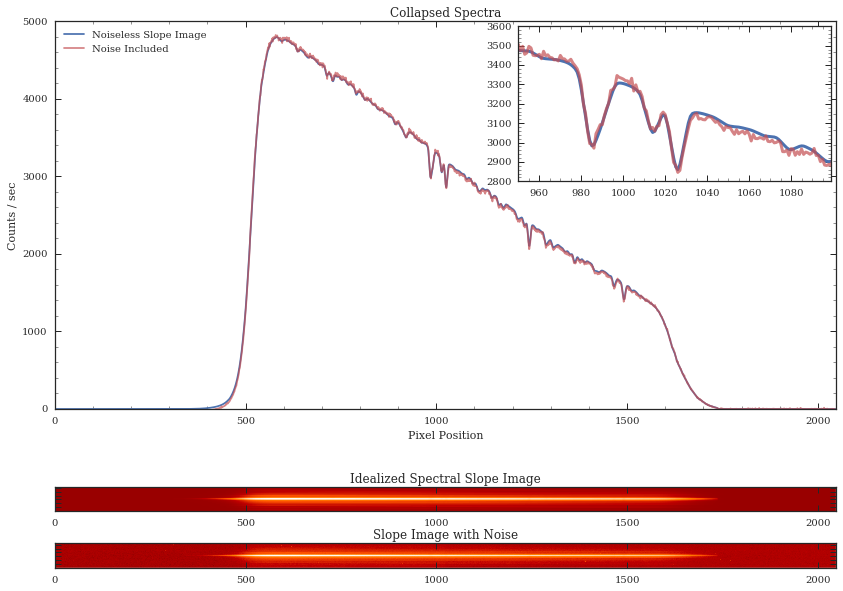

In [61]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
colors = sns.color_palette()

fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(10,1)
ax1 = fig.add_subplot(gs[:-3, :])
ax2 = fig.add_subplot(gs[-2, :])
ax3 = fig.add_subplot(gs[-1, :])

# Collapsed spectra
c1 = im_slope.sum(axis=0)
c1 -= np.median(c1[1900:])
c2 = im_slope_sim.sum(axis=0)
c2 -= np.median(c2[1900:])

xvals = np.arange(len(c1))
ax1.plot(xvals, c1, label='Noiseless Slope Image')
ax1.plot(xvals, c2, color=colors[2], alpha=0.7, label='Noise Included')
ax1.set_ylabel('Counts / sec')
ax1.set_xlabel('Pixel Position')
ax1.set_title('Collapsed Spectra')
ax1.minorticks_on()
ax1.legend(loc=2)
ax1.set_xlim([0,2047])
ax1.set_ylim([0,5000])

inset_axes = inset_axes(ax1, width="40%",height="40%",loc=1)
inset_axes.plot(xvals, c1, lw=3)
inset_axes.plot(xvals, c2, lw=3, color=colors[2], alpha=0.7)
inset_axes.set_xlim([950,1099])
inset_axes.set_ylim([2800,3600])
inset_axes.minorticks_on()

# Show the 2D spectral image as well
vmin = 1e-2
vmax = im_slope.max()
#print(vmax)
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ax2.imshow(im_slope, norm=norm)
ax2.set_yticklabels('')
ax2.set_title('Idealized Spectral Slope Image')

ax3.imshow(im_slope_sim, norm=norm)
ax3.set_yticklabels('')
ax3.set_title('Slope Image with Noise')

In [43]:
current_palette = sns.color_palette()

In [44]:
current_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]